In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from modules.Table import TableUserInferface

In [2]:
tui_actual = TableUserInferface()
tui_actual.calc_heatmaps_kpis()

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 35909
Setting CH edge vector of size 79532
Range graph removed 79532 edges of 159064
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [3]:
tui_futuro = TableUserInferface()
tui_futuro.change_scenario(1)
tui_futuro.calc_heatmaps_kpis()

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 35909
Setting CH edge vector of size 79532
Range graph removed 79532 edges of 159064
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 36891
Setting CH edge vector of size 81446
Range graph removed 81446 edges of 162892
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [4]:
tui_actual.save_heatmaps()
tui_futuro.save_heatmaps()

Directorio '/app/data/output/amenities_proximity/actual' creado con éxito.
Carpeta '/app/data/output/amenities_proximity' comprimida en '/app/data/output/zip/amenities_proximity.zip' con éxito.
Directorio '/app/data/output/green_areas_proximity/actual' creado con éxito.
Carpeta '/app/data/output/green_areas_proximity' comprimida en '/app/data/output/zip/green_areas_proximity.zip' con éxito.
Directorio '/app/data/output/land_uses_diversity/actual' creado con éxito.
Carpeta '/app/data/output/land_uses_diversity' comprimida en '/app/data/output/zip/land_uses_diversity.zip' con éxito.
Directorio '/app/data/output/amenities_proximity/future' creado con éxito.
Carpeta '/app/data/output/amenities_proximity' comprimida en '/app/data/output/zip/amenities_proximity.zip' con éxito.
Directorio '/app/data/output/green_areas_proximity/future' creado con éxito.
Carpeta '/app/data/output/green_areas_proximity' comprimida en '/app/data/output/zip/green_areas_proximity.zip' con éxito.
Directorio '/app/d

In [9]:
tui_actual.get_travels_green_areas_by_class('PARQUE').to_file('/app/data/output/green_areas_proximity/actual/parque')
tui_actual.get_travels_green_areas_by_class('PLAZA').to_file('/app/data/output/green_areas_proximity/actual/plaza')
tui_futuro.get_travels_green_areas_by_class('PARQUE').to_file('/app/data/output/green_areas_proximity/future/parque')
tui_futuro.get_travels_green_areas_by_class('PLAZA').to_file('/app/data/output/green_areas_proximity/future/plaza')

<Axes: >

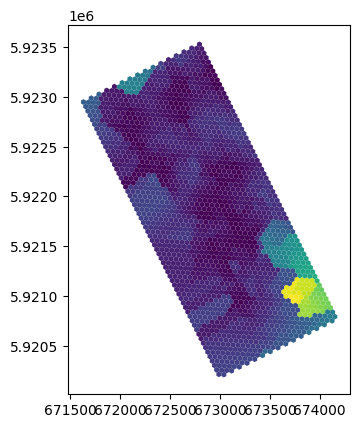

In [8]:
tui_futuro.get_travels_green_areas_by_class('PLAZA').plot(column='travel_time')

<Axes: >

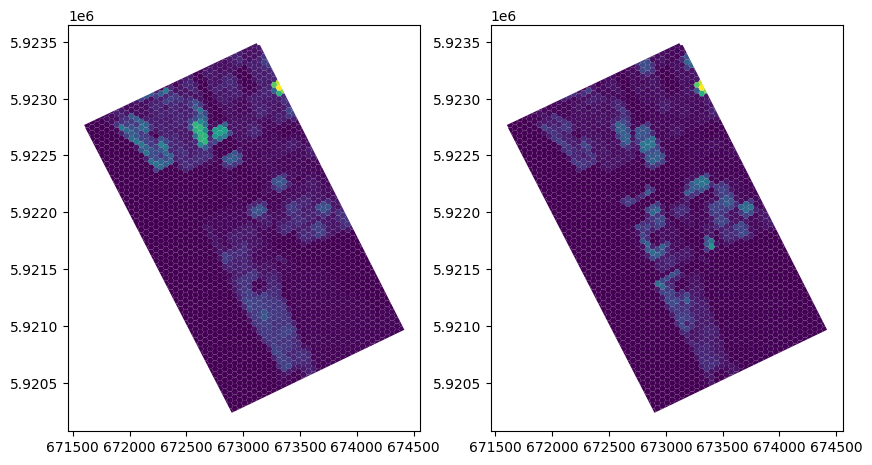

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))
tui_actual.population_density.plot(column='density', ax=ax[0])
tui_futuro.population_density.plot(column='density', ax=ax[1])

<Axes: >

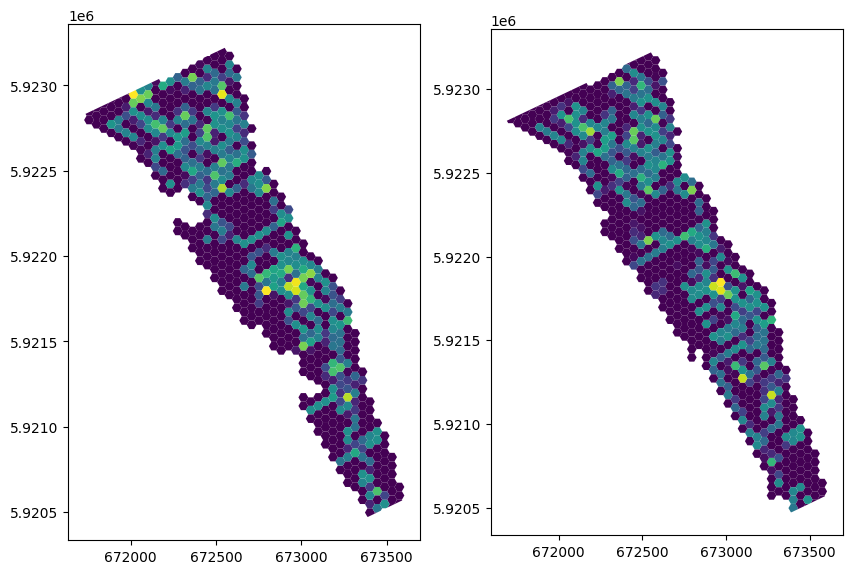

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))
tui_actual.lu_diversity.plot(column='diversity', ax=ax[0])
tui_futuro.lu_diversity.plot(column='diversity', ax=ax[1])

<Axes: >

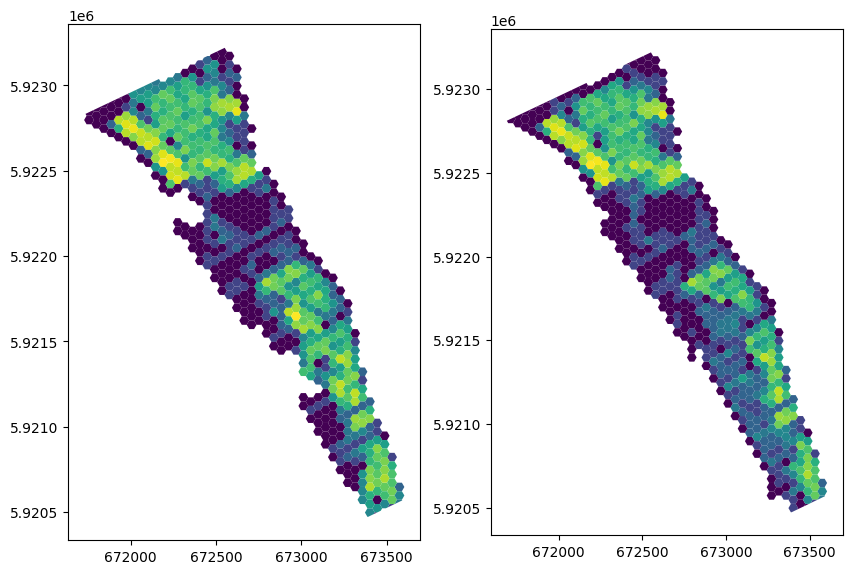

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))
tui_actual.lu_diversity.plot(column='diversity', ax=ax[0])
tui_futuro.lu_diversity.plot(column='diversity', ax=ax[1])

<Axes: >

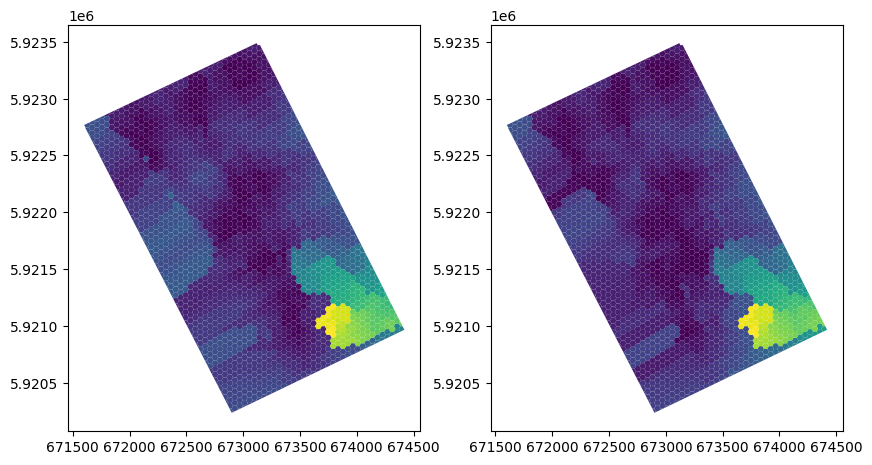

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))
tui_actual.get_travels_green_areas_by_class('PLAZA').plot(column='travel_time', ax=ax[0])
tui_futuro.get_travels_green_areas_by_class('PLAZA').plot(column='travel_time', ax=ax[1])

<Axes: >

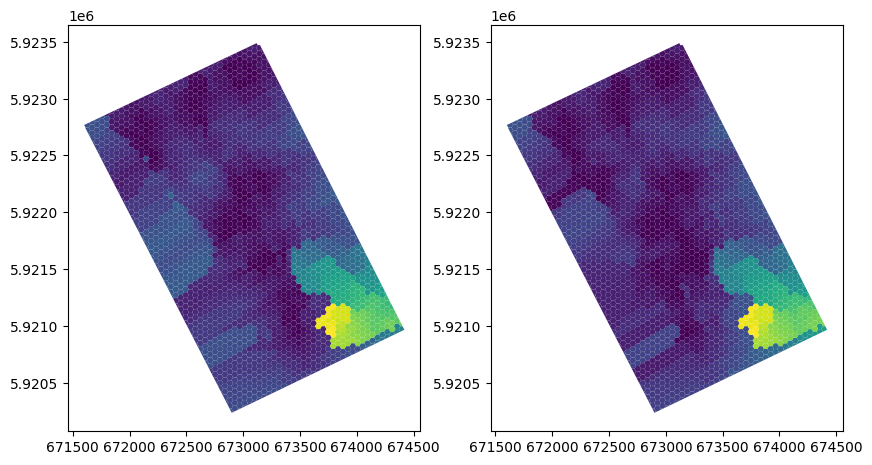

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))
tui_actual.get_travels_green_areas_by_class('PLAZA').plot(column='travel_time', ax=ax[0])
tui_futuro.get_travels_green_areas_by_class('PLAZA').plot(column='travel_time', ax=ax[1])

In [20]:
tui_actual.get_amenities_categories()

['Entretenimiento',
 'Comida para servir',
 'Servicios',
 'Aprovisionamiento',
 'Transporte publico',
 'Educacion',
 'Cuidados',
 'Comercio',
 'Cultura']

<Axes: >

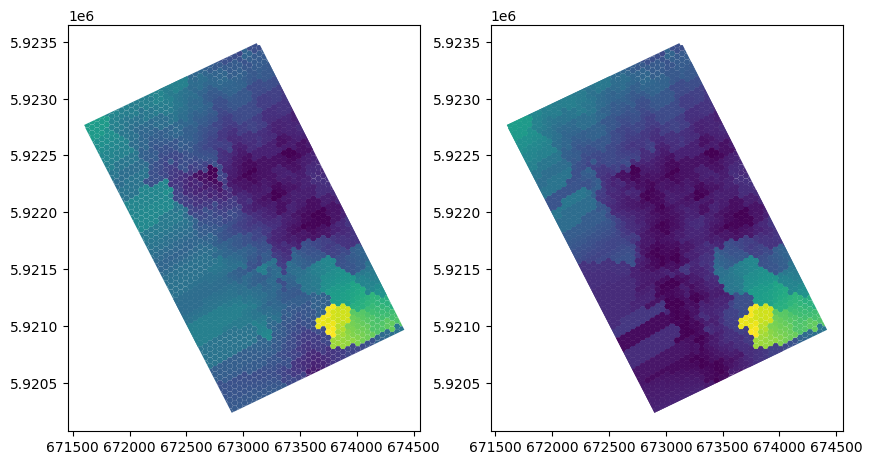

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))

tui_actual.get_travels_amenities_by_category('Aprovisionamiento').plot(column='travel_time', ax=ax[0])
tui_futuro.get_travels_amenities_by_category('Aprovisionamiento').plot(column='travel_time', ax=ax[1])

In [42]:
tui = TableUserInferface()

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 35909
Setting CH edge vector of size 79532
Range graph removed 79532 edges of 159064
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [43]:
unit = tui.unit
lands = tui.lu.get_current_land_uses()

In [122]:
intersection = gpd.overlay(unit, lands, how='intersection')
intersection['area_pol_inter'] = intersection.area
intersection['area_unit'] = intersection['area']
inter_cols = [f'{tui.select_unit}_id', 'Uso', 'area', 'area_pol_inter', 'area_unit', 'area_predio']
intersection = intersection[inter_cols]
uses_inter_area = intersection.groupby(['hex_id', 'Uso'])['area_pol_inter'].agg('sum').reset_index()
total_inter_area = intersection.groupby(['hex_id'])['area_pol_inter'].agg('sum').reset_index().rename(columns={'area_pol_inter': 'inter_area'})
uses_inter_area = pd.merge(uses_inter_area, total_inter_area)
uses_inter_area = pd.merge(uses_inter_area, unit[['hex_id', 'area']].rename(columns={'area': 'unit_area'}))
uses_inter_area['property_percentage'] = uses_inter_area['area_pol_inter']/uses_inter_area['inter_area']
uses_inter_area['information_per_property'] = -1*uses_inter_area['property_percentage']*np.log(uses_inter_area['property_percentage'])
diversity = uses_inter_area.groupby(f'hex_id')['information_per_property'].agg('sum').reset_index()

diversity_map = pd.merge(diversity, unit, on=f'hex_id')
diversity_map.rename(columns={'information_per_property': 'diversity'}, inplace=True)
diversity_map = gpd.GeoDataFrame(data=diversity_map['diversity'], geometry=diversity_map['geometry'])

In [75]:
def calc_land_uses_diversity(tui):
    tui.unit['area_unit'] = tui.unit.area
    # Intersection between land_uses and units
    intersection = gpd.overlay(tui.unit, tui.lu.get_current_land_uses(), how="intersection")
    intersection['area'] = intersection.area

    # Filter intersection geodataframe by columns
    inter_cols = [f'{tui.select_unit}_id', 'Uso', 'area', 'area_unit', 'area_predio']
    intersection = intersection[inter_cols]

    total_inter_area = intersection.groupby([f'{tui.select_unit}_id'])['area'].agg('sum').reset_index().rename(columns={'area': 'inter_area'})
    # display(tui.unit)
    # display(total_inter_area)
    intersection = pd.merge(intersection, total_inter_area, on=f'{tui.select_unit}_id')
    intersection['property_percentage'] = intersection['area']/intersection['inter_area']
    intersection['information_per_property'] = -1*intersection['property_percentage']*np.log(intersection['property_percentage'])
    # display(intersection)

    diversity = intersection.groupby(f'{tui.select_unit}_id')['information_per_property'].agg('sum').reset_index()
    diversity_map = pd.merge(diversity, tui.unit, on=f'{tui.select_unit}_id')
    diversity_map.rename(columns={'information_per_property': 'diversity'}, inplace=True)
    tui.unit.drop(columns=['area_unit'], inplace=True)
    return gpd.GeoDataFrame(data=diversity_map['diversity'], geometry=diversity_map['geometry'])

diversity = calc_land_uses_diversity(tui_actual)
diversity.head()

,diversity,geometry
0,0.626808,"POLYGON Z ((672853.678 5921496.707 0.000, 6728..."
1,0.692592,"POLYGON Z ((672694.907 5922071.707 0.000, 6726..."
2,0.000000,"POLYGON Z ((672810.377 5922071.707 0.000, 6727..."
3,0.685798,"POLYGON Z ((672694.907 5922071.707 0.000, 6726..."
4,0.679875,"POLYGON Z ((672117.557 5922821.707 0.000, 6720..."


In [3]:
tui.calc_travel_time_to_green_areas()

<Axes: >

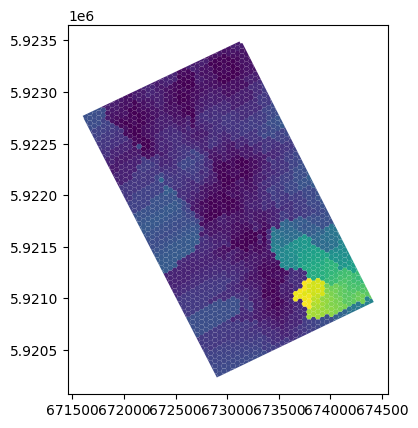

In [10]:
paths = tui.gdf_ga_paths
paths[paths['class']=='SQ'].plot(column='travel_time')

In [5]:
# greenareas = tui.ga.node_set
# units = tui.unit
net = tui.st.current_scenario['net']

In [6]:
nodes = net.node_ids.values

In [78]:
source = units[['hex_id', 'node_ids']]
destination = greenareas[['ID_AV', 'osmid']]

import pandas as pd
import itertools

# Supongamos que tienes dos DataFrames df1 y df2

# Genera todas las combinaciones posibles entre los registros de los DataFrames
combinations = list(itertools.product(source.to_records(index=False), destination.to_records(index=False)))

# Crea una nueva lista con 4 registros por elemento
nueva_lista = [list(item1) + list(item2) for item1, item2 in combinations]

df_columns = ['hex_id', 'source', 'ID_AV', 'destination']
# Crea un DataFrame a partir de las combinaciones
df_combinations = pd.DataFrame(nueva_lista, columns=df_columns)

In [79]:
df_combinations['path_lenghts'] = net.shortest_path_lengths(df_combinations['source'], df_combinations['destination'])

In [80]:
df_combinations['class'] = df_combinations['ID_AV'].str[:2]

In [81]:
min_lenght_idx = df_combinations.groupby(['hex_id', 'class'])['path_lenghts'].idxmin().reset_index()
min_paths = df_combinations.loc[min_lenght_idx['path_lenghts']]

In [82]:
from modules.myfunctions import *
min_paths.apply()

,hex_id,source,ID_AV,destination,path_lenghts,class
167,0,6762930952,PK19,4186110396,221.082,PK
237,0,6762930952,SQ24,9684415457,763.816,SQ
268,1,2093018636,PK1,1850412734,605.697,PK
354,1,2093018636,SQ10,892390584,1408.032,SQ
512,2,9665359133,PK1,1825504547,83.395,PK
...,...,...,...,...,...,...
580488,2331,11057538621,SQ3,310072970,327.228,SQ
580720,2332,9816166317,PK1,9731319240,479.444,PK
580799,2332,9816166317,SQ15,1825504476,667.774,SQ
580966,2333,303526618,PK1,9665359129,445.442,PK


Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 36894
Setting CH edge vector of size 81442
Range graph removed 81442 edges of 162884
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


<Axes: >

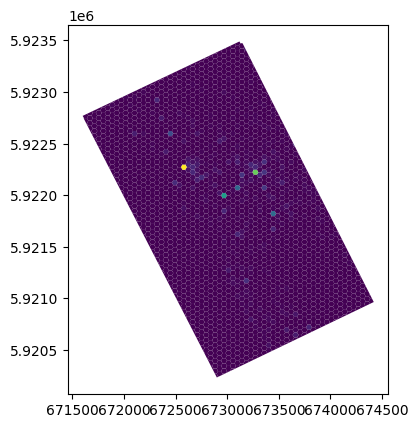

In [3]:
tui.change_scenario(1)
tui.load_unit('hex')
tui.calc_amenities_density()
tui.amenities_density.plot('density')

In [25]:
unit = tui.unit.copy()
select_unit = tui.select_unit
amenities = tui.get_amenities().get_current_amenities().copy()

join_result = gpd.sjoin(amenities, unit, how='inner', op='within')
# count_by_unit = join_result.groupby(f'{select_unit}_id')['counter'].agg('sum').reset_index()
count_by_unit = join_result.groupby(f'{select_unit}_id').size().reset_index(name='amenities_count')
count_by_unit = pd.merge(count_by_unit, unit, on=[f'{select_unit}_id'], how='outer')
count_by_unit['amenities_count'].fillna(0, inplace=True)
count_cols = ['hex_id', 'amenities_count', 'centroid']
count_by_unit = gpd.GeoDataFrame(data=count_by_unit[count_cols], geometry=count_by_unit['geometry'])

<Axes: >

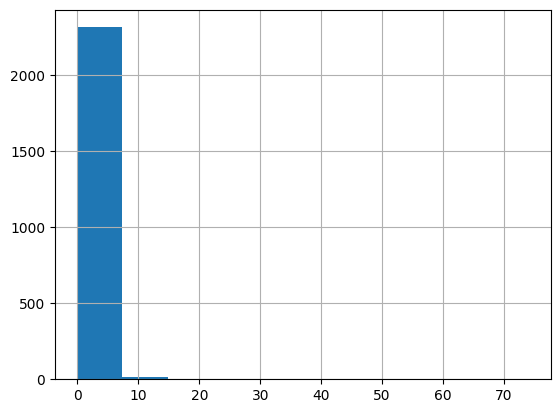

In [119]:
count_by_unit['amenities_count'].hist()

<Axes: >

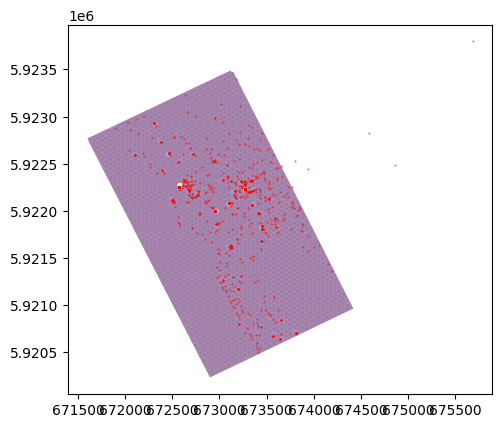

In [120]:
fig, ax = plt.subplots()
count_by_unit.plot(ax=ax, column='amenities_count', alpha=0.5)
amenities.plot(ax=ax, color='red',markersize=0.1)

<Axes: >

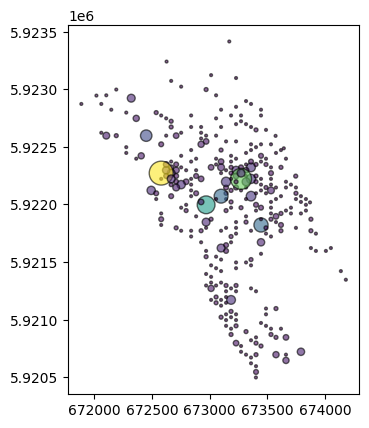

In [124]:
count_cols = [f'{select_unit}_id', 'amenities_count', 'centroid', 'geometry']
count_by_unit.loc[count_by_unit['amenities_count']>0,count_cols].drop(columns=['geometry']).rename(columns={'centroid': 'geometry'}).plot(
    column='amenities_count', markersize=4*count_by_unit['amenities_count'], alpha=0.6, edgecolor='black')

<Axes: >

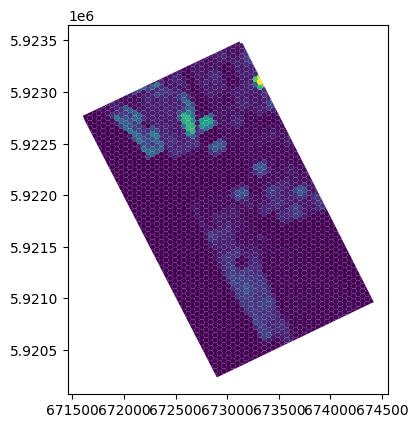

In [16]:
tui.change_scenario(0)
tui.calc_population_density()
tui.population_density.plot(column='density')

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 36894
Setting CH edge vector of size 81442
Range graph removed 81442 edges of 162884
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


<Axes: >

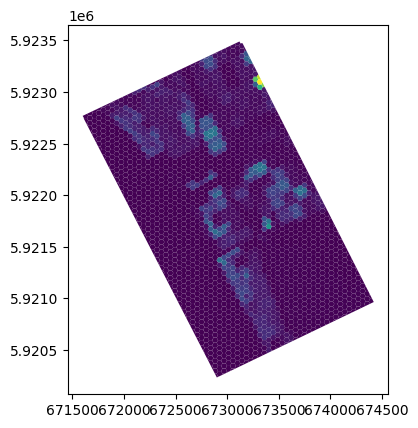

In [17]:
tui.change_scenario(1)
tui.calc_population_density()
tui.population_density.plot(column='density')

tui.calc_heatmaps_kpis()

tui.get_travels_amenities_by_category('Comercio').plot(column='travel_time')

In [69]:
tui_scenarios = {}
for scenario_id in [0, 1]:
    tui.change_scenario(scenario_id)
    tui.calc_heatmaps_kpis()
    tui_scenarios[scenario_id] = tui

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 36894
Setting CH edge vector of size 81442
Range graph removed 81442 edges of 162884
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [50]:
tui.get_amenities_categories()

['Entretenimiento',
 'Comida para servir',
 'Servicios',
 'Aprovisionamiento',
 'Transporte publico',
 'Educacion',
 'Cuidados',
 'Comercio',
 'Cultura']

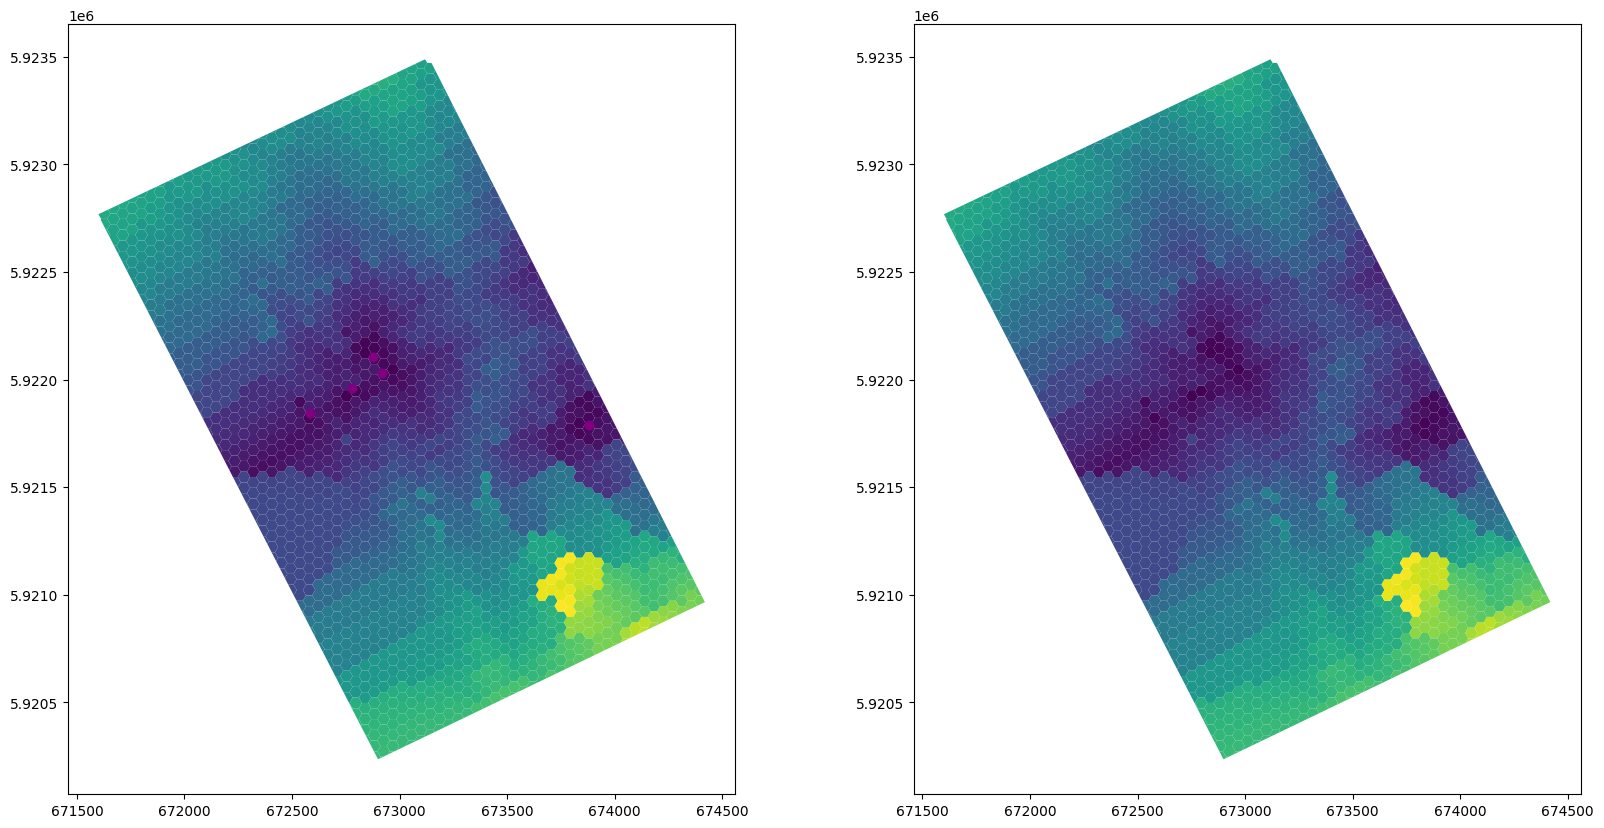

In [71]:
category = 'Cultura'
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(20,10))

for scenario_id in [0, 1]:
    tui_scenarios[scenario_id].get_travels_amenities_by_category(category).plot(column='travel_time', ax=ax[scenario_id])
    gpd.sjoin(
        tui_scenarios[scenario_id].get_amenities().get_current_amenities_by_category(category),
        tui_scenarios[scenario_id].st.area_scope,
        ).plot(ax=ax[0], color='purple')

<Axes: >

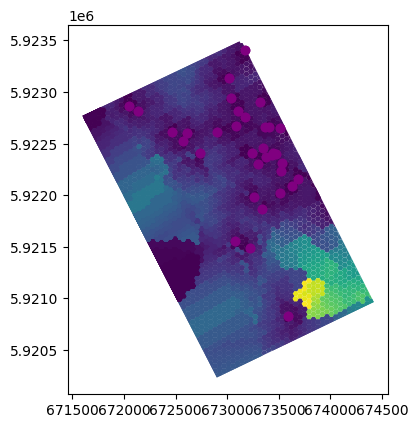

In [44]:
# for scenario in [0, 1]:
#     tui.change_scenario(scenario_id=scenario)
#     tui.calc_land_uses_diversity()
#     tui.save_land_uses_diversity()

In [22]:
import geopandas as gpd
hex_area = gpd.read_file('/app/data/hexagonos_50')

In [23]:
hex_area.rename(columns={'id': 'hex_id'}, inplace=True)

In [24]:
hex_area.to_parquet('/app/assets/groupby/hex.parquet')

In [8]:
grid = gpd.read_file('/app/data/cuadricula')

In [9]:
grid.rename(columns={'id': 'grid_id'}, inplace=True)

In [10]:
grid.to_parquet('/app/assets/groupby/grid.parquet')